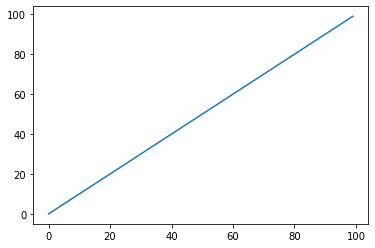

In [1]:
import matplotlib.pyplot as plt

plt.plot(range(0,100,1))

In [2]:
import torch
from PIL import Image
from collections import namedtuple
from torchvision import models
 
import argparse
import os
import sys
import time
import re
 
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx
import tarfile

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [4]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(9):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 18):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(18, 27):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(27, 36):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_4 = h
        h = self.slice3(h)
        h_relu4_4 = h
        h = self.slice4(h)
        h_relu5_4 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu2_2, h_relu3_4, h_relu4_4, h_relu5_4)
        return out

In [5]:
class ResidualDense(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(ResidualDense, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, hidden_channels, kernel_size = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_channels, in_channels, kernel_size = 1),
            torch.nn.ReLU()
        )
    
    def forward(self, X):
        return X - self.model(X)

class ConditionerNet(torch.nn.Module):
    def __init__(self):
        super(ConditionerNet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(4, 1000, kernel_size = 1),
            torch.nn.ReLU(),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            ResidualDense(1000, 1000),
            torch.nn.Conv2d(1000, 4224, kernel_size = 1)
        )
    
    def forward(self, X):
        return self.model(X)


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = ConvLayer(3, 32, kernel_size = 9, stride = 1) 
        self.in1 = ContitionalInstanceNorm2d()

        self.conv2 = ConvLayer(32, 64, kernel_size = 3, stride = 2)
        self.in2 = ContitionalInstanceNorm2d()

        self.conv3 = ConvLayer(64, 128, kernel_size = 3, stride = 2)
        self.in3 = ContitionalInstanceNorm2d()

        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.res6 = ResidualBlock(128)
        self.res7 = ResidualBlock(128)

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size = 3, stride = 1, upsample = 2)
        self.in4 = ContitionalInstanceNorm2d()
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size = 3, stride = 1, upsample = 2)
        self.in5 = ContitionalInstanceNorm2d()
        self.deconv3 = ConvLayer(32, 3, kernel_size = 9, stride = 1)
        self.relu = torch.nn.ReLU()

    def forward(self, X, gammas, betas):
        y = self.relu(self.in1(self.conv1(X), gammas[:,0:32,:,:], betas[:,0:32,:,:]))
        y = self.relu(self.in2(self.conv2(y), gammas[:,32:96,:,:], betas[:,32:96,:,:]))
        y = self.relu(self.in3(self.conv3(y), gammas[:,96:224,:,:], betas[:,96:224,:,:]))
        y = self.res1(y, gammas[:,224:480,:,:], betas[:,224:480,:,:])
        y = self.res2(y, gammas[:,480:736,:,:], betas[:,480:736,:,:])
        y = self.res3(y, gammas[:,736:992,:,:], betas[:,736:992,:,:])
        y = self.res4(y, gammas[:,992:1248,:,:], betas[:,992:1248,:,:])
        y = self.res5(y, gammas[:,1248:1504,:,:], betas[:,1248:1504,:,:])
        y = self.res6(y, gammas[:,1600:1856,:,:], betas[:,1600:1856,:,:])
        y = self.res7(y, gammas[:,1856:2112,:,:], betas[:,1856:2112,:,:])
        y = self.relu(self.in4(self.deconv1(y), gammas[:,1504:1568,:,:], betas[:,1504:1568,:,:]))
        y = self.relu(self.in5(self.deconv2(y), gammas[:,1568:1600,:,:], betas[:,1568:1600,:,:]))
        y = self.deconv3(y) 
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = ContitionalInstanceNorm2d()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = ContitionalInstanceNorm2d()
        self.relu = torch.nn.ReLU()

    def forward(self, x, gammas, betas):
        residual = x
        out = self.relu(self.in1(self.conv1(x), gammas[:,0:self.channels,:,:], betas[:,0:self.channels,:,:]))
        out = self.in2(self.conv2(out), gammas[:,self.channels:self.channels * 2,:,:], betas[:,self.channels:self.channels * 2,:,:])
        out = out + residual # need relu right after
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

class ContitionalInstanceNorm2d(torch.nn.Module):
    def __init__(self):
        super(ContitionalInstanceNorm2d, self).__init__()
    
    def forward(self, x, gammas, betas):
        std = x.std(dim = [2, 3], keepdim=True)
        mean = x.mean(dim = [2, 3], keepdim=True)

        l = (x - mean) / std

        return l * gammas + betas

In [6]:
def FileExtension(file_name):
    """Return the file extension of file
    'file' should be a string. It can be either the full path of
    the file or just its name (or any string as long it contains
    the file extension.)
    Example #1:
    input (file) -->  'abc.tar.gz'
    return value -->  'tar.gz'
    
    Example #2:
    input (file) -->  'abc.tar'
    return value -->  'tar'
    
    """
    match = re.compile(r"^.*?[.](?P<ext>tar[.]gz|tar[.]bz2|\w+)$",
      re.VERBOSE|re.IGNORECASE).match(file_name)

    if match:           # if match != None:
        ext = match.group('ext')
        return ext
    else:
        return ''       # there is no file extension to file_name

def Extract(tarfile_fullpath, output_folder_path, delete_tar_file=False):
    """Extract the tarfile_fullpath to an appropriate* folder of the same
    name as the tar file (without an extension) and return the path
    of this folder.
    If delete_tar_file is True, it will delete the tar file after
    its extraction; if False, it won`t. Default value is True as you
    would normally want to delete the (nested) tar files after
    extraction. Pass a False, if you don`t want to delete the
    tar file (after its extraction) you are passing.
    """
    try:
        tar = tarfile.open(tarfile_fullpath)
        tar.extractall(output_folder_path)
        tar.close()
        if delete_tar_file: os.remove(tarfile_fullpath)
        return output_folder_path

    except Exception:
        global error_count
        error_count += 1

def WalkTreeAndExtract(parent_dir, output_dir):
    """Recursively descend the directory tree rooted at parent_dir
    and extract each tar file on the way down (recursively)."""
    try:
        dir_contents = os.listdir(parent_dir)
    except OSError:
        # Exception can occur if trying to open some folder whose
        # permissions this program does not have.
        global error_count
        error_count += 1
        return

    for content in dir_contents:
        content_fullpath = os.path.join(parent_dir, content)
        if os.path.isdir(content_fullpath):
            # If content is a folder, walk down it completely.
            WalkTreeAndExtract(content_fullpath, output_dir)
        elif os.path.isfile(content_fullpath):
            # If content is a file, check if it is a tar file.
            if FileExtension(content_fullpath) in file_extensions:
                # If yes, extract its contents to a new folder.
                extract_folder_name = Extract(content_fullpath, output_dir)
                if extract_folder_name:     # if extract_folder_name != None:
                    dir_contents.append(extract_folder_name)
                    # Append the newly extracted folder to dir_contents
                    # so that it can be later searched for more tar files
                    # to extract.

def ExtractNested(tarfile_fullpath, output_folder_path):
    extract_folder_name = Extract(tarfile_fullpath, output_folder_path)
    if extract_folder_name:         # if extract_folder_name != None
      dir_contents = os.listdir(extract_folder_name)
      for content in dir_contents:
        print(content)
        content_fullpath = os.path.join(extract_folder_name, content)
        # If content is a file, check if it is a tar file.
        if FileExtension(content_fullpath) in file_extensions:
            # If yes, extract its contents to a new folder.
            extract_folder_name = Extract(content_fullpath, output_folder_path, delete_tar_file=True)

file_extensions = ('tar', 'tgz', 'tbz', 'tb2', 'tar.gz', 'tar.bz2')

os.path.isdir("../../../../data/ILSVRC2012/train/")
#!rm -rf 'Training Data/Images'
#!mkdir 'Training Data/Images'
#!ls 'Training Data/Images'
#ExtractNested("./ILSVRC2012_img_train_t3.tar", "./Training Data/Images/")

False

In [12]:
def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)

def load_weights(model, conditioner, transformer):
    if model is not None:
        state_dict = torch.load(model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        transformer.load_state_dict(state_dict)

        csd = torch.load(model+'.cond.pth')
        conditioner.load_state_dict(csd)        


def train(train_dataset_dir, style_image, style_size=None, image_size=256, learning_rate=1e-3, epochs=2, batch_size=4, content_weight=1e5
          , style_weight=1e10, log_interval=500, checkpoint_interval=2000, seed=0, checkpoint_model_dir="./Checkpoints/"
          , cuda=False, save_model_dir="./Complete Models/", model=None):
    device = torch.device("cuda" if cuda else "cpu")
    
    loss_emas = []
    loss_contents = []
    total_losses = []
    
    print(device)

    np.random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(train_dataset_dir, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    conditioner = ConditionerNet().to(device)
    transformer = TransformerNet().to(device)
    load_weights(model, conditioner, transformer)
    optimizer = Adam(transformer.parameters(), learning_rate)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg19(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(style_image, size=style_size)
    style = style_transform(style)
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]
    loss_ema = torch.ones(4).to(device)
    layer_loss = torch.ones(4).to(device)
    ema_alpha = 0.01

    for e in range(epochs):
        print("Epoch: " + str(e))
        if(e > 0):
            print("Agg. Content Loss: " + str(agg_content_loss))
            print("Agg. Style Loss: " + str(agg_style_loss))
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            if(batch_id % 100 == 0):
                print("Batch: " + str(batch_id))
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)

            if (torch.rand(1).item() > 0.5):
                stylization_vector = torch.rand(4).to(device)
            else:
                stylization_vector = torch.zeros(4).to(device)
                stylization_vector[batch_id % 4] = 1

            c_values = conditioner(
                torch.ones(n_batch, 4, 1, 1).to(device) * stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

            gammas = c_values[:, 0:2112, :, :]
            betas = c_values[:, 2112:4224, :, :]

            y = transformer(x, gammas, betas)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for i, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                gm_y = gram_matrix(ft_y)
                ll = mse_loss(gm_y, gm_s[:n_batch, :, :]) * style_weight
                style_loss += (loss_ema.sum() / loss_ema[i]) * ll * stylization_vector[i]
                layer_loss[i] = ll.detach()

            loss_ema = ema_alpha * layer_loss + (1 - ema_alpha) * loss_ema

            total_loss = content_loss + style_loss
            if(batch_id % 100 == 0):
                print("Loss: " + str(total_loss))
            total_loss.backward()
            optimizer.step()
            
            loss_emas.append(style_loss.item())
            loss_contents.append(content_loss.item())
            total_losses.append(total_loss.item())
            
#             if(batch_id % 1000 == 0):
#                 losses = pd.Series(loss_emas, index=range(len(loss_emas)))
#                 style_stds = losses.rolling(80).std()
#                 style_means = losses.rolling(80).mean()
#                 plt.plot(losses.index, losses, 'b')
#                 plt.plot(style_stds.index, style_means+style_stds, 'r')
#                 plt.plot(style_stds.index, style_means-style_stds, 'r')
#                 plt.plot(style_means.index, style_means, 'k')
#                 plt.title("Style Loss")
#                 plt.show()
                
#                 losses = pd.Series(loss_contents, index=range(len(loss_emas)))
#                 stds = losses.rolling(80).std()
#                 means = losses.rolling(80).mean()
#                 plt.plot(losses.index, losses, 'b')
#                 plt.plot(stds.index, means+stds, 'r')
#                 plt.plot(stds.index, means-stds, 'r')
#                 plt.plot(means.index, means, 'k')
#                 plt.title("Content Loss")
#                 plt.show()
                
#                 losses = pd.Series(total_losses, index=range(len(loss_emas)))
#                 stds = losses.rolling(80).std()
#                 means = losses.rolling(80).mean()
#                 plt.plot(losses.index, losses, 'b')
#                 plt.plot(stds.index, means+stds, 'r')
#                 plt.plot(stds.index, means-stds, 'r')
#                 plt.plot(means.index, means, 'k')
#                 plt.title("Total Loss")
#                 plt.show()

            agg_content_loss += content_loss.item()
            agg_style_loss += loss_ema.sum()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                torch.save(conditioner.state_dict(), ckpt_model_path+'.cond.pth')
                transformer.to(device).train()
                
                ckpt_loss_filename = "./Loss Plots/ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1)
                
                losses = pd.Series(loss_emas, index=range(len(loss_emas)))
                style_stds = losses.rolling(80).std()
                style_means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(style_stds.index, style_means+style_stds, 'r')
                plt.plot(style_stds.index, style_means-style_stds, 'r')
                plt.plot(style_means.index, style_means, 'k')
                plt.title("Style Loss")
                plt.savefig(ckpt_loss_filename + "_style.png", format="png")
                plt.clf()
#                 plt.show()
                
                losses = pd.Series(loss_contents, index=range(len(loss_emas)))
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Content Loss")
                plt.savefig(ckpt_loss_filename + "_content.png", format="png")
                plt.clf()
#                 plt.show()
                
                losses = pd.Series(total_losses, index=range(len(loss_emas)))
                stds = losses.rolling(80).std()
                means = losses.rolling(80).mean()
                plt.plot(losses.index, losses, 'b')
                plt.plot(stds.index, means+stds, 'r')
                plt.plot(stds.index, means-stds, 'r')
                plt.plot(means.index, means, 'k')
                plt.title("Total Loss")
                plt.savefig(ckpt_loss_filename + "_total.png", format="png")
                plt.clf()
#                 plt.show()

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_').replace(':', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(conditioner.state_dict(), save_model_path+'.cond.pth')
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)
    return save_model_path


def stylize(content_image, output_image_path, model_path, content_scale=None, animate=0, export_onnx_path=False, cuda=False):
    device = torch.device("cuda" if cuda else "cpu")
    print(device)

    content_image = load_image(content_image, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if model_path.endswith(".onnx"):
        output = stylize_onnx_caffe2(content_image, export_onnx_path, model_path, cuda)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(model_path)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)

            conditioner = ConditionerNet()
            csd = torch.load(model_path+'.cond.pth',map_location=torch.device('cpu'))
            conditioner.load_state_dict(csd)
            conditioner.to(device)

            if export_onnx_path:
                assert export_onnx_path.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(style_model, content_image, export_onnx_path).cpu()
            else:
                if animate:
                    keypoints = [
                        torch.tensor([0., 0, 1, 0]),
                        torch.tensor([0., 1, 0, 1]),
                        torch.tensor([1., 0, 0, 0]),
                        torch.tensor([1., 1, 1, 1]),
                        torch.tensor([0., 0, 0, 0]),
                        torch.tensor([0., 0, 0, 1]),
                    ]

                    for frame in range(0, 750):
                        start = frame // 150
                        end = start + 1

                        stylization_vector = keypoints[start].lerp(keypoints[end], (frame % 150) / 150).to(device)

                        c_values = conditioner(
                            stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                        gammas = c_values[:, 0:2112, :, :]
                        betas = c_values[:, 2112:4224, :, :]  

                        output = style_model(content_image, gammas, betas).cpu()
                        save_image(output_image_path + "." + str(frame) + ".jpg", output[0])
                else:
                    stylization_vector = torch.tensor([1., 1, 1, 1]).to(device)

                    c_values = conditioner(
                        stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                    gammas = c_values[:, 0:2112, :, :]
                    betas = c_values[:, 2112:4224, :, :]  

                    output = style_model(content_image, gammas, betas).cpu()
    save_image(output_image_path, output[0])


def stylize_onnx_caffe2(content_image, export_onnx, model_path, cuda):
    """
    Read ONNX model and run it using Caffe2
    """

    assert not export_onnx

    import onnx
    import onnx_caffe2.backend

    model = onnx.load(model_path)

    prepared_backend = onnx_caffe2.backend.prepare(model, device='CUDA' if cuda else 'CPU')
    inp = {model.graph.input[0].name: content_image.numpy()}
    c2_out = prepared_backend.run(inp)[0]

    return torch.from_numpy(c2_out)

In [48]:
model_final_path = train("../../../../data/ILSVRC2012/train", "./Style Images/Swirly2.jpg", epochs=2, cuda=True, checkpoint_interval=2000)

cuda
Epoch: 0
Batch: 0
Loss: tensor(10744563., device='cuda:0', grad_fn=<AddBackward0>)
Batch: 100
Loss: tensor(9061672., device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [13]:
stylize("./n02098286_6245.JPEG", "./Output/output.jpg", "./saved_models/ckpt_epoch_0_batch_id_50000.pth", animate=0)

cpu


In [9]:
import seaborn as sn

def create_layer_loss_plots(content_image, model_path, content_scale=None, cuda=False, style_image="./Swirly2.jpg", grain=0.1):
    device = torch.device("cuda" if cuda else "cpu")
    print(device)

    content_image = load_image(content_image, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():

        #Load Networks
        style_model = TransformerNet()
        state_dict = torch.load(model_path)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)

        conditioner = ConditionerNet()
        csd = torch.load(model_path+'.cond.pth', map_location=torch.device('cpu'))
        conditioner.load_state_dict(csd)
        conditioner.to(device)
        
        frob_norm = torch.norm

        vgg = Vgg19(requires_grad=False).to(device)
        
        style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
        ])
        style = load_image(style_image, size=None)
        style = style_transform(style)
        style = style.repeat(1, 1, 1, 1).to(device)

        features_style = vgg(normalize_batch(style))
        gram_style = [gram_matrix(y) for y in features_style]

        layer_losses = np.zeros((2, 3, len(np.arange(0, 1.1, grain))))
        for others in range(2):
            for i in range(1,4):
                for val in np.arange(0, 1.1, grain):
                    if(others == 0):
                        stylization_vector = torch.zeros(4)
                    else:
                        stylization_vector = torch.ones(4)

                    stylization_vector[i] = val


                    c_values = conditioner(stylization_vector.unsqueeze(0).unsqueeze(2).unsqueeze(2))

                    gammas = c_values[:, 0:2112, :, :]
                    betas = c_values[:, 2112:4226, :, :]

                    y = style_model(content_image, gammas, betas)
                    x = content_image

                    y = y
                    x = x

                    features_y = vgg(y)
                    features_x = vgg(x)

                    style_loss = 0.
                    for j, (ft_y, gm_s) in enumerate(zip(features_y, gram_style)):
                        if(j == i):
                            gm_y = gram_matrix(ft_y)
                            ll = torch.mean(torch.square(frob_norm((gm_y - gm_s[:, :, :]), dim=(1,2)))) #* style_weight
                            layer_losses[others][i-1][int(val/grain)] = ll.detach()

        zero_losses = layer_losses[0]
        one_losses = layer_losses[1]
        
        plt.rcParams["figure.figsize"] = (3.3,3)
        colours = ['b','g','r']

        for i in range(3):
            losses = zero_losses[i]
            losses -= np.min(np.abs(losses))
            losses /= np.max(np.abs(losses))
            sn.lineplot(x = np.arange(0, 1.1, grain), y = losses, label=("Conv" + str(i+2)), color=colours[i], marker='o')
        plt.xlabel("Input Parameter Value")
        plt.ylabel("Normalised Style Loss")
        plt.show()

        for i in range(3):
            losses = one_losses[i]
            losses -= np.min(np.abs(losses))
            losses /= np.max(np.abs(losses))
            sn.lineplot(x = np.arange(0, 1.1, grain), y = losses, label=("Conv" + str(i+2)), color=colours[i], marker='o')
        plt.xlabel("Input Parameter Value")
        plt.ylabel("Normalised Style Loss")
        plt.show()
        
        return (zero_losses, one_losses)

cpu
Starting Others = 0
Starting Layer = 1
Starting Value = 0.0
tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [126.5259,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[364.8468, 482.9132, 205.6928,  ..., 270.1508, 350.0007, 363.5026],
          [ 22.6301,  48.5910,   0.0000,  ...,  69.5205, 225.4439, 354.1682],
          [  0.0000, 106.6473,  66.8787,  ...,   0.0000,  70.8172, 266.4435],
          ...,
          [226.4399,   0.0000,   0.0000,  ...,   9.5400, 224.6235, 483.5247],
          [278.0610,   0.0000,   0.0000,  ...,   0.0000, 186.8318, 427.5877],
          [421.0478,  25.1421,  11.4467,  ...,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 71.5678,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[315.6913, 320.6945,  91.4424,  ..., 167.1089, 261.1589, 232.6145],
          [ 42.4817,   0.0000,   0.0000,  ...,  40.4734, 140.9604, 171.5148],
          [  0.0000,  53.8263,  73.7504,  ...,   0.0000,   0.0000,  83.9701],
          ...,
          [291.5946,   0.0000,   0.0000,  ...,   0.0000, 147.3249, 240.7072],
          [146.0676,   0.0000,   0.0000,  ...,   0.0000, 177.5564, 218.8949],
          [263.2870,   0.0000,   0.0000,  ..., 148.2051, 316.0297, 309.9067]],

         [[  0.0000,   0.0000,

tensor([[[[195.5597,  48.0475,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 65.4509,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 95.9126,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[ 59.7214,   0.0000,  47.0315,  ...,  97.2622, 113.8059, 147.0011],
          [  0.0000,   0.0000,   0.0000,  ...,  62.2108,  66.5393, 112.4292],
          [  0.0000,   0.0000, 148.8784,  ...,   0.0000,  47.8908,  90.5983],
          ...,
          [323.6051,   0.0000,   0.0000,  ...,   0.0000, 172.3278, 283.4393],
          [107.2998,   0.0000,   0.0000,  ...,  19.1120,  91.3023, 155.5322],
          [403.7107,   0.0000,   0.0000,  ..., 312.4804, 295.4813, 279.2212]],

         [[  0.0000,   0.0000,

tensor([[[[ 334.6555,  280.5057,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [  78.5174,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [  19.1950,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000]],

         [[   5.8122,    0.0000,  352.0492,  ...,   12.2877,  122.3440,
            174.3971],
          [   0.0000,    0.0000,   22.8607,  ...,    0.0000,   25.2457,
            143.7667],
          [   0.0000,   12.3227,  696.5848,  ...,    0.0000,    0.0000,
            114.7932],
          ...,
          [ 141.3293,    0.0000,    0.0000,  ...,    0.0000,  142.2593,
            321.5620],
          [   9.32

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   5.0240,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   8.8772,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.6717],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   5.7147,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[4.2970, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[177.3808, 228.7269, 260.5541,  ..., 238.7595, 216.2462, 278.9943],
          [ 37.3205,   0.0000,   0.0000,  ...,  49.2306, 143.2571, 305.7011],
          [181.5613, 140.1355, 115.5535,  ...,   0.0000,  98.7607, 331.7285],
          ...,
          [  0.0000,   0.0000,   0.0000,  ..., 120.7804,  68.4494, 358.4734],
          [  0.0000,   0.0000,   0.0000,  ..., 218.7386,  74.1122, 245.7870],
          [ 34.8996,   0.0000, 184.8096,  ..., 444.0228, 358.4159, 411.0384]],

         [[ 75.8159,   0.0000,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[ 86.7903,  91.5412, 155.8866,  ..., 238.5822, 179.4918, 259.3171],
          [  0.0000,   0.0000,   0.0000,  ...,   1.4031,  70.5007, 287.2544],
          [ 55.7720, 100.0975,  71.3714,  ...,   0.0000,  56.0968, 321.3068],
          ...,
          [  0.0000,   0.0000,   0.0000,  ..., 123.1652,  78.2981, 398.3311],
          [  0.0000,   0.0000,   0.0000,  ..., 226.2980, 120.8571, 231.7340],
          [151.7991,   0.0000, 209.2923,  ..., 485.4732, 422.5551, 404.4948]],

         [[ 18.7244,   0.0000,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[257.5603, 139.7306,  34.1918,  ..., 203.2097, 123.9184, 217.0836],
          [ 64.3158,   0.0000,   0.0000,  ...,  24.9265,  24.4134, 242.8633],
          [ 37.2371, 103.0618,  27.3541,  ...,   3.2307,  40.2046, 282.3417],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  30.1524, 433.0339],
          [  0.0000,   0.0000,   0.0000,  ...,  60.1925,  63.8346, 276.2548],
          [243.0742,   0.0000, 142.2699,  ..., 470.4462, 442.7128, 483.0464]],

         [[ 15.4474,   7.9210,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [163.8150,  65.2245,  58.3801,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 14.5746,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  14.3485]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[  0.0000,   0.0000,  53.7269,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [170.5346,  98.6242, 192.0876,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  35.6641],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  19.9044]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,  11.1411,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[  0.0000,   0.0000,  42.1404,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [126.3376,  40.0521,  61.2150,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  52.3668],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   5.5188],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  12.0988]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  40.4828],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ 14.6920,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   6.4428]],

         [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   9.8754],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

         [[  0.0000,   0.0000,

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.4494],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.8192],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

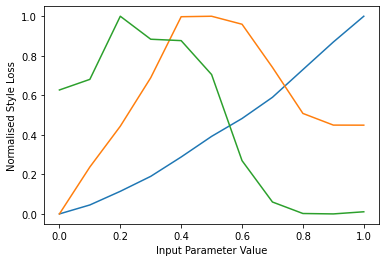

C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\charl\Anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

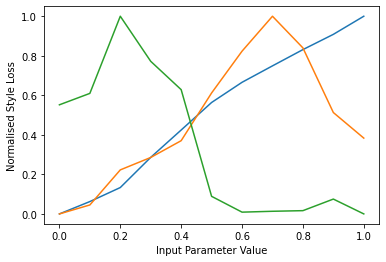

In [10]:
(zero_losses, one_losses) = create_layer_loss_plots("./n02098286_6245.JPEG", "./saved_models/ckpt_epoch_0_batch_id_50000.pth", grain=0.1)